Binary Classification using a linear neural network with PyTorch

In [167]:
import torch
from torch import nn
from torch.utils import data
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification

We use scikit learn to generate points in 2D

In addition, load_array creates a DataLoader for training

In [168]:
def synthetic_data(num_examples):
    X, Y = make_classification(n_samples=num_examples, n_features=2, n_redundant=0, n_informative=2,
                             n_clusters_per_class=1)
    return X, Y


def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

these are the two training functions; the first one training on a subset of the training data (as provided by train_iter) and the second one calling the first one for num_epoch times.

In [169]:
def train_epoch(net, train_iter, loss, updater):
    """The training loop defined in Chapter 3."""
    # Set the model to training mode
    # if isinstance(net, torch.nn.Module):
    net.train()
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X.float())
        l = loss(y_hat, y)
        # Using PyTorch in-built optimizer & loss criterion
        updater.zero_grad()
        l.backward()
        updater.step()


def train(net, train_iter, loss, num_epochs, updater):
    """Train a model (defined in Chapter 3)."""
    for epoch in range(num_epochs):
        train_epoch(net, train_iter, loss, updater)

In [181]:
# we want to classify a 2-d input into 2 classes
# TODO fix the warning about missing dimension
net = nn.Sequential(nn.Linear(2, 2), nn.Softmax())


def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

# our loss function in case of classification
loss = nn.CrossEntropyLoss()


trainer = torch.optim.SGD(net.parameters(), lr=0.1)
# trainer = torch.optim.Adam(net.parameters(), lr=0.001)


batch_size = 10

features, labels = synthetic_data(100)
f = torch.tensor(features)
l = torch.tensor(labels)

data_iter = load_array((f, l), batch_size)


num_epochs = 10
# and actually train the network
train(net, data_iter, loss, num_epochs, trainer)

/usr/lib/python3.9/site-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [171]:
# we can take a look at the weights of the NN after training
# net[0].weight

Now we actually use the NN

We will plot one NN output as we move along a line in the 2D area

In [172]:
# let's create a range of elements...
xpred = torch.tensor(np.linspace(-4,4,100))

In [173]:
# stack them together with something constant
inp = torch.stack((xpred, torch.ones_like(xpred)), dim=-1)

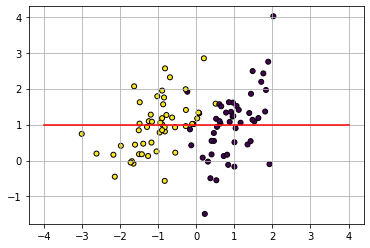

In [182]:
# let's plot the data
plt.scatter(f[:, 0], f[:, 1], marker='o', c=l, s=25, edgecolor='k')
# and the line along we plot the NN output
plt.plot(inp[:, 0], inp[:, 1], c='r')

plt.grid()
plt.show()

In [175]:
# using the NN for "point-wise" prediction
xtest=torch.tensor([0, -2])
net(xtest.float())

/usr/lib/python3.9/site-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([0.4544, 0.5456], grad_fn=<SoftmaxBackward>)

In [183]:
# input the points on the line into the NN
prob = net(inp.float())

/usr/lib/python3.9/site-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


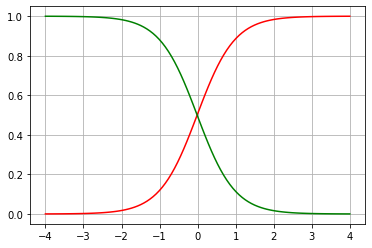

In [184]:
# and plot the corresponding NN output
plt.plot(xpred,prob[:,0].detach().numpy(), '-r')
plt.plot(xpred,prob[:,1].detach().numpy(), '-g')
plt.grid(True)

## Understanding what's going on

Our NN performs an affine transformation of the 2 input values $x_1, x_2$. The output of the transform is not immedaitely visible in the NN above, but let's call it $z_1, z_2$ and is given as 

$$
z_1 = w_{1,1} x_1 + w_{1,2}x_2 + b_1
$$

and

$$
z_2 = w_{2,1} x_1 + w_{2,2} x_2 + b_2
$$

These two values are then "soft-maxed"; i.e. normalized that they lie within $[0,1]$ and both sum up to one. We are interested in the borderline; i.e. the line in the $x_1 - x_2$ plane where $y_1 = y_2 = 1/2$. This is equivalent to $z_1 = z_2 = 0$ and knowing the weights and bias of the NN, we can calulate this border line.

Setting $z_1=0$ and solving for $x_2$, we obtain

$$
x_2 = -\frac{1}{w_{1,2}}(b_1 + w_{1,1} x_1)
$$

In [185]:
net[0].weight, net[0].bias

(Parameter containing:
 tensor([[ 1.0134, -0.0915],
         [-1.0109,  0.0998]], requires_grad=True),
 Parameter containing:
 tensor([0.3345, 0.1192], requires_grad=True))

In [186]:
w11 = net[0].weight[0,0].detach().numpy()
w12 = net[0].weight[0,1].detach().numpy()
b1 = net[0].bias[0].detach().numpy()

w11, w12, b1

(array(1.0134152, dtype=float32),
 array(-0.09146564, dtype=float32),
 array(0.33446556, dtype=float32))

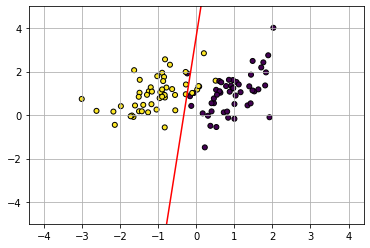

In [190]:
yborder = -1/w12*(b1 + w11*xpred.numpy())

fig, ax = plt.subplots()

# let's plot the data
plt.scatter(f[:, 0], f[:, 1], marker='o', c=l, s=25, edgecolor='k')
# and the line along we plot the NN output
ax.plot(xpred, yborder, c='r')

plt.grid()
ax.set_ylim(-5,5)
plt.show()